In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import sys
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import os
from pprint import pprint
import warnings
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pystan.misc # in model.fit(): AttributeError: module 'pystan' has no attribute 'misc'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
!pip install optuna
import optuna
optuna.logging.disable_default_handler()
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import csv

from google.colab import files
# src = list(files.upload().values())[0]
open('/content/drive/My Drive/Corona_virus/covid_19_function.py','wb').write(src)
import covid_19_function as func

In [0]:
path = '/content/drive/My Drive/Corona_virus/'
dta = pd.read_csv(path+'train_data.csv')
change_date = pd.read_csv(path+'change_date.csv')
# sir_pred = pd.read_csv(path+'sir_predict.csv')
# sird_pred = pd.read_csv(path+'sird_predict.csv')
# trend_predict = pd.read_csv(path+'trend_predict.csv')
# sir_pred = sir_pred.rename({'Time': 'Date', 'Susceptible': 'Sir_Susceptible',
#                             'Infected': 'Sir_infacted', 
#                             'Recovered/Deaths': 'Sir_deaths_recover'}, axis = 1)

# sird_pred = sird_pred.rename({'Time': 'Date', 'Susceptible': 'Sird_Susceptible',
#                             'Infected': 'Sird_infacted', 
#                             'Recovered': 'Sird_recover', 'Deaths': 'Sird_deaths'}, axis = 1)

# sir_pred["Date"] = pd.to_datetime(sir_pred["Date"])
# sird_pred["Date"] = pd.to_datetime(sird_pred["Date"])
# trend_predict["Date"] = pd.to_datetime(trend_predict["Date"])

dta["Date"] = pd.to_datetime(dta["Date"])

# dta['Date'] = dta['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
aa = lambda x : (1 if (x > 0 and x <= 7) else 
                 (2 if (x > 7 and x <= 14) else 
                  (3 if (x > 14 and x <= 21) else 
                   (4 if (x > 21 and x <= 28) else 
                    (5 if (x > 28) else 0)))))

dta = dta.sort_values(by=['Territory', 'Date'])
dta['Daily_deaths'] = dta.groupby(['Territory'])['target'].diff()
dta.loc[dta['Daily_deaths'].isna(),'Daily_deaths'] = dta[dta['Daily_deaths'].isna()]['target']
# dta['Daily_cases'] = dta.groupby(['Territory'])['cases'].diff()
# dta.loc[dta['Daily_cases'].isna(),'Daily_cases'] = dta[dta['Daily_cases'].isna()]['cases']
# dta['Daily_recover'] = dta.groupby(['Territory'])['Recover'].diff()
# dta.loc[dta['Daily_recover'].isna(),'Daily_recover'] = dta[dta['Daily_recover'].isna()]['Recover']
dta['Day'] = pd.DatetimeIndex(dta['Date']).day
dta['Month'] = pd.DatetimeIndex(dta['Date']).month
# dta['Week'] = pd.DatetimeIndex(dta['Date']).week
# dta['Week_of_month'] = (dta['Day']-1)//7.0+1


# lag_until1 = 1

# lag_var(dt = dta, target = 'Daily_deaths', 
#         lag_list = range(1,lag_until1), 
#         group_vars = ['Territory'],
#         name_prefix = 'lag_deaths')

# lag_until2 = 1
# lag_var(dt = dta, target = 'Daily_cases', 
#         lag_list = range(1,lag_until2), 
#         group_vars = ['Territory'],
#         name_prefix = 'lag_cases')

# df = dta.merge(trend_predict, how = 'left', left_on= ['Territory', 'Date'], right_on= ['Country', 'Date'] )
# df.loc[df['tr_ts']==1,:] = df.loc[df['tr_ts']==1,:].fillna(0)
# df1 = df.merge(sir_pred, how = 'left', left_on= ['Territory', 'Date'], right_on= ['Country', 'Date'] )
# df1.loc[df1['tr_ts']==1,:] = df1.loc[df1['tr_ts']==1,:].fillna(0)
# df2 = df1.merge(sird_pred, how = 'left', left_on= ['Territory', 'Date'], right_on= ['Country', 'Date'] )
# df2.loc[df2['tr_ts']==1,:] = df2.loc[df2['tr_ts']==1,:].fillna(0)

# dta = df2.copy()
# del df, df1, df2

dta['target1'] = dta['target']
dta['cases1'] = dta['cases']
dta['Recover1'] = dta['Recover']

dta['target'] = dta['Sird_deaths']
dta['cases'] = dta['Sird_infacted']
dta['Recover'] = dta['Sird_recover']

ncases = [1, 50, 100, 500, 2000, 5000]
# ncases = [1]
for i in ncases:
    dta = func.cases_grow(dta, '1st_cases_country'+str(i), n_cases = i)


ndeaths = [1, 10, 50, 150, 300]
# ndeaths = [1]
for i in ndeaths:
    dta = func.death_grow(dta, '1st_deaths_country'+str(i), n_deaths = i)


nrecover = [1]
for i in nrecover:
    dta = func.recover_grow(dta, '1st_recover_country'+str(i), n_recover = i)


for i in ncases:
    dta[str(i)+'days_cases_country'] = dta['Diff_1st_cases_country'+str(i)].apply(aa)

for i in ndeaths:
    dta[str(i)+'days_deaths_country'] = dta['Diff_1st_deaths_country'+str(i)].apply(aa)

for i in nrecover:
    dta[str(i)+'days_recover_country'] = dta['Diff_1st_recover_country'+str(i)].apply(aa)

    
dta = dta.rename({'Territory': 'Country', 'target': 'Deaths', 'cases': 'Confirmed',
                         'Recover': 'Recovered'}, axis = 1)
dta['Province']='-'
dta.loc[:,"Time"] = pd.to_datetime(dta.loc[:,'Date'], infer_datetime_format=True)
dta = pd.concat([dta.reset_index(drop=True), 
                 pd.get_dummies(dta['Cluster_territory'],  prefix="Cluster", 
                                drop_first=True, dtype=float)],axis = 1)

dta['target'] = dta['target1']
dta['cases'] = dta['cases1']
dta['Recover'] = dta['Recover1']
dta["Infected"] = dta["Confirmed"] - dta["Deaths"] - dta["Recovered"]

In [0]:
# dta

In [0]:
# dta.isna().sum().to_dict()

In [0]:
# df = dta.merge(trend_predict, how = 'left', on = ['Country', 'Date'])
# df.loc[df['tr_ts']==1,:] = df.loc[df['tr_ts']==1,:].fillna(0)
# df1 = df.merge(sir_pred, how = 'left', on = ['Country', 'Date'])
# df1.loc[df1['tr_ts']==1,:] = df1.loc[df1['tr_ts']==1,:].fillna(0)
# df2 = df1.merge(sird_pred, how = 'left', on = ['Country', 'Date'])
# df2.loc[df2['tr_ts']==1,:] = df2.loc[df2['tr_ts']==1,:].fillna(0)
# df = df.dropna(axis = 0)

# df.loc[df['tr_ts']==1,:].isna().sum().to_dict()
# df.isna().sum().to_dict()
# df.loc[df['Trend_Confirmed'].isna(),]
# dta.columns
# dta = df





In [0]:
# df1.loc[df1['Sir_Susceptible'].isna(),]
# dta.isna().sum().to_dict()

In [0]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}

df = dta[['Date','Country', 'Province', 'tr_ts', *data_cols_all]]
df = df.fillna(0)
df[data_cols_all] = df.loc[:,data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
# ncov_df_ungrouped


In [0]:
# population = dta[['Country', 'SP.POP.TOTL']].drop_duplicates()
# population = population.rename({"SP.POP.TOTL": "Population"}, axis=1)
# population_dict = population.set_index("Country").to_dict()["Population"]
# # population_dict

In [0]:
ncov_df = func.growth_data(ncov_df_ungrouped)
ncov_df.head()
df = ncov_df[['Group', 'Country']].drop_duplicates()
dta = dta.merge(df, how='left', on=['Country'])
dta = pd.concat([dta.reset_index(drop=True), 
                 pd.get_dummies(dta['Group'],  prefix="Group", 
                                drop_first=True, dtype=float)],axis = 1)


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [0]:
def fit_data(dt, test_date = '07Apr2020', random_var = False, 
             var_prop = .75, var_list=None, seed = 123):
  
    x_var = ['Time', 'Time2', 'Time3', 'Lat', 'Long', 
            'distance_1', 'distance_2', 'distance_3', 'distance_4',
              'NY.GDP.PCAP.CD',
          'NY.GNP.PCAP.CD', 'SH.IMM.IDPT', 'SH.IMM.HEPB', 'SH.IMM.MEAS',
          'SH.TBS.INCD', 'ST.INT.ARVL', 'AG.LND.TOTL.K2', 'TX.VAL.MRCH.WL.CD',
          'TX.VAL.MRCH.HI.ZS', 'TM.VAL.MRCH.HI.ZS', 'TG.VAL.TOTL.GD.ZS',
          'NY.GSR.NFCY.CD', 'SP.POP.0014.TO.ZS', 'SP.POP.1564.TO.ZS',
          'SP.POP.65UP.TO.ZS', 'EN.POP.DNST', 'SP.POP.TOTL', 'SP.RUR.TOTL.ZS',
          'BG.GSR.NFSV.GD.ZS', 'SH.TBS.DTEC.ZS', 'EG.ELC.ACCS.ZS',
          'SP.DYN.LE00.IN', 'SM.POP.NETM', 'SH.TBS.CURE.ZS', 'SH.UHC.SRVS.CV.XD',
          'SH.DTH.COMM.ZS', 'SH.XPD.CHEX.PC.CD', 'SH.XPD.GHED.PC.CD',
          'SH.XPD.PVTD.PC.CD', 'SM.POP.TOTL.ZS',   
              'Diff_1st_cases_country1',
          'Diff_1st_cases_country50', 'Diff_1st_cases_country100',
          'Diff_1st_cases_country500', 'Diff_1st_cases_country2000',
          'Diff_1st_cases_country5000', 'Diff_1st_deaths_country1',
          'Diff_1st_deaths_country10', 'Diff_1st_deaths_country50',
          'Diff_1st_deaths_country150', 'Diff_1st_deaths_country300',
          'Diff_1st_recover_country1', '1days_cases_country',
          '50days_cases_country', '100days_cases_country',
          '500days_cases_country', '2000days_cases_country',
          '5000days_cases_country', '1days_deaths_country',
          '10days_deaths_country', '50days_deaths_country',
          '150days_deaths_country', '300days_deaths_country',
          '1days_recover_country',
              'Trend_Confirmed', 'Trend_Deaths', 'Trend_Recovered', 'Sir_Susceptible',
          'Sir_infacted', 'Sir_deaths_recover', 'Sird_Susceptible',
          'Sird_infacted', 'Sird_recover', 'Sird_deaths',
          'Cluster_1',
          'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6',
          'Cluster_7', 'Cluster_8', 'Cluster_9', 'Group_Outbreaking',
          'Group_Stopping']


    y_var = 'Daily_deaths'
    dt['Time'] = dt['Time'].astype(int)
    dt['Time2'] = (dt['Time'] - dt['Time'].mean()).pow(2) 
    dt['Time3'] = (dt['Time'] - dt['Time'].mean()).pow(3)

    if random_var:
      import random
      random.seed( seed )
      rnd = random.sample(range(3, len(x_var)), int(var_prop*len(x_var)))
      x_var1 = [x_var[i] for i in rnd]
      x_var = ['Time', 'Time2', 'Time3'] + x_var1
      # print(x_var)

    if var_list is not None:
      x_var = var_list

    # print(x_var)
    std = StandardScaler()
    std = std.fit(dt[[*x_var]])


    tr_ts_date = datetime.strptime(test_date, '%d%b%Y')
    x_train = dt.loc[dt['Date']<=tr_ts_date, x_var]
    y_train = dt.loc[dt['Date']<=tr_ts_date, y_var]
    date_coun_tr = dt.loc[dt['Date']<=tr_ts_date, ['Date', 'Country']]

    x_test = dt.loc[dt['Date']>tr_ts_date, x_var]
    y_test = dt.loc[dt['Date']>tr_ts_date, y_var]
    date_coun_ts = dt.loc[dt['Date']>tr_ts_date, ['Date', 'Country']]

    x_train = std.transform(x_train)
    x_test = std.transform(x_test)

    return ([x_train, y_train, x_test, y_test, x_var, date_coun_tr, date_coun_ts])
# dt = dta
# y_train.dtypes

# x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
#                                                           random_var = True, 
#                                                           var_prop = .5)


## SVM

In [0]:
from sklearn import svm

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False, 
                                                          var_prop = .5, 
                                                          seed = 123)
svr_pram = {'kernel':('poly', 'rbf', 'sigmoid'), 
              'C':np.linspace(1e-8,1, 30),
              'epsilon': np.linspace(1e-8,.2, 10)}
svr = svm.SVR()
svr_clf = GridSearchCV(svr, svr_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 5)
svr_clf.fit(x_train, y_train)

svr_best_pram = svr_clf.best_estimator_
svr_rank = pd.DataFrame(svr_clf.cv_results_)
svr_rank = svr_rank.loc[svr_rank['rank_test_score']<6,:].sort_values('rank_test_score')
svr_rank.to_csv(path+'svr_rank.csv', index=False )

file1 = open(path+"svr_best_parm.txt","w") 
file1.write(str(svr_best_pram)) 
file1.close()



## Random Forest Regression

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
x_train, y_train, x_test, y_test, selected_var , dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False, 
                                                          var_prop = .5, 
                                                          seed = 123)
rf_pram = {'n_estimators': [30,  50, 80, 100, 150], 
              'max_depth':[3, 4,5,6],
              'min_samples_leaf': [15, 20, 25, 30 , 50]}

rf = RandomForestRegressor(random_state=1, 
                           criterion='mae', max_features='sqrt')
rf_clf = GridSearchCV(rf, rf_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 5)
rf_clf.fit(x_train, y_train)

rf_best_pram = rf_clf.best_estimator_
rf_rank = pd.DataFrame(rf_clf.cv_results_)
rf_rank = rf_rank.loc[rf_rank['rank_test_score']<6,:].sort_values('rank_test_score')
rf_rank.to_csv(path+'rf_rank.csv', index=False )

file1 = open(path+"rf_best_parm.txt","w") 
file1.write(str(rf_best_pram)) 
file1.close()

## Spline Regression

In [0]:
!pip install sklearn-contrib-py-earth
# !pip install earth
from pyearth import Earth
import warnings
warnings.filterwarnings("ignore", message="`rcond` parameter will change to the default")

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False, 
                                                          var_prop = .5, 
                                                          seed = 123)
spr_pram = {'max_degree': [1,2], 
            'penalty':np.linspace(1e-8, 80, 200)}

spr =  Earth(smooth=True)
spr_clf = GridSearchCV(spr, spr_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 5)
spr_clf.fit(x_train, y_train)

spr_best_pram = spr_clf.best_estimator_
spr_rank = pd.DataFrame(spr_clf.cv_results_)
spr_rank = spr_rank.loc[spr_rank['rank_test_score']<6,:].sort_values('rank_test_score')
spr_rank.to_csv(path+'spr_rank.csv', index=False )

file1 = open(path+"spr_best_parm.txt","w") 
file1.write(str(spr_best_pram)) 
file1.close()

## Spline Regression Subset 1

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = True, 
                                                          var_prop = .5, 
                                                          seed = 123)
spr_pram = {'max_degree': [1,2], 
            'penalty':np.linspace(5, 30, 10)}

spr =  Earth(smooth=True)
spr_clf = GridSearchCV(spr, spr_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 5)
spr_clf.fit(x_train, y_train)

spr_best_pram = spr_clf.best_estimator_
spr_rank = pd.DataFrame(spr_clf.cv_results_)
spr_rank = spr_rank.loc[spr_rank['rank_test_score']<6,:].sort_values('rank_test_score')
spr_rank.to_csv(path+'spr_rank_1.csv', index=False )

file1 = open(path+"spr_best_parm_1.txt","w") 
file1.write(str(spr_best_pram)) 
file1.write('\n\n\n')
file1.write(str(selected_var))
file1.close()

## Spline Regression Subset 2

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = True, 
                                                          var_prop = .5, 
                                                          seed = 234)
spr_pram = {'max_degree': [1,2], 
            'penalty':np.linspace(5, 30, 10)}

spr =  Earth(smooth=True)
spr_clf = GridSearchCV(spr, spr_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 5)
spr_clf.fit(x_train, y_train)

spr_best_pram = spr_clf.best_estimator_
spr_rank = pd.DataFrame(spr_clf.cv_results_)
spr_rank = spr_rank.loc[spr_rank['rank_test_score']<6,:].sort_values('rank_test_score')
spr_rank.to_csv(path+'spr_rank_2.csv', index=False )

file1 = open(path+"spr_best_parm_2.txt","w") 
file1.write(str(spr_best_pram)) 
file1.write('\n\n\n')
file1.write(str(selected_var))
file1.close()

## Spline Regression Subset 3

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = True, 
                                                          var_prop = .5, 
                                                          seed = 342)
spr_pram = {'max_degree': [1,2], 
            'penalty':np.linspace(1e-8, 15, 10)}

spr =  Earth(smooth=True)
spr_clf = GridSearchCV(spr, spr_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 5)
spr_clf.fit(x_train, y_train)

spr_best_pram = spr_clf.best_estimator_
spr_rank = pd.DataFrame(spr_clf.cv_results_)
spr_rank = spr_rank.loc[spr_rank['rank_test_score']<6,:].sort_values('rank_test_score')
spr_rank.to_csv(path+'spr_rank_3.csv', index=False )

file1 = open(path+"spr_best_parm_3.txt","w") 
file1.write(str(spr_best_pram)) 
file1.write('\n\n\n')
file1.write(str(selected_var))
file1.close()

## Spline Regression Subset 4

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = True, 
                                                          var_prop = .5, 
                                                          seed = 431)
spr_pram = {'max_degree': [1,2], 
            'penalty':np.linspace(15, 30, 10)}

spr =  Earth(smooth=True)
spr_clf = GridSearchCV(spr, spr_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 5)
spr_clf.fit(x_train, y_train)

spr_best_pram = spr_clf.best_estimator_
spr_rank = pd.DataFrame(spr_clf.cv_results_)
spr_rank = spr_rank.loc[spr_rank['rank_test_score']<6,:].sort_values('rank_test_score')
spr_rank.to_csv(path+'spr_rank_4.csv', index=False )

file1 = open(path+"spr_best_parm_4.txt","w") 
file1.write(str(spr_best_pram)) 
file1.write('\n\n\n')
file1.write(str(selected_var))
file1.close()

## XGBoost Regression

In [0]:
import xgboost as xgb

In [0]:
xgb_pram = {'n_estimators': [50, 80, 100, 120, 150, 200], 
            'max_depth': [3,4,5,6,7],
            'learning_rate': [1e-8],
            'gamma': np.linspace(1e-8, 5, 25),
            'subsample': np.linspace(.1, 1, 10),
            'reg_alpha': [1e-8]}

xgbr =  xgb.XGBRegressor(objective='reg:squarederror', booster='gblinear', 
                        eval_metric = 'mae', verbosity = 0)
xgb_clf = GridSearchCV(xgbr, xgb_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 5)
xgb_clf.fit(x_train, y_train)

xgb_best_pram = xgb_clf.best_estimator_
xgb_rank = pd.DataFrame(xgb_clf.cv_results_)
xgb_rank = xgb_rank.loc[xgb_rank['rank_test_score']<6,:].sort_values('rank_test_score')
xgb_rank.to_csv(path+'xgb_rank.csv', index=False )

file1 = open(path+"xgb_best_parm.txt","w") 
file1.write(str(xgb_best_pram)) 
file1.close()

## Neural Network

In [0]:
from sklearn.neural_network import MLPRegressor

In [0]:
# nn_pram = {'hidden_layer_sizes': [(5,), (10,), (20,), (50,), (10,5), (20, 10), 
#                                   (30,15), (20, 10, 5), (30, 15, 10)], 
#            'alpha': np.linspace(1e-8, 3, 10),
#             'beta_1': np.linspace(1e-8, 1, 10),
#             'beta_2': np.linspace(1e-8, 1, 10),
#             'epsilon': np.linspace(1e-8, 1, 10),
#             'n_iter_no_change': [10, 20, 30]}

nn_pram = {'hidden_layer_sizes': [(5,), (10,), (20,), (50,), (10,5)], 
           'alpha': np.linspace(1e-8, 1, 5),
            'beta_1': np.linspace(1e-8, 1, 5),
            'beta_2': np.linspace(1e-8, 1, 5),
            'epsilon': np.linspace(1e-8, 1, 5),
            'n_iter_no_change': [10]}



nn =  MLPRegressor(activation='relu', solver='adam',
                    learning_rate = 'adaptive', max_iter = 5000, warm_start=True,
                    early_stopping = True, validation_fraction= .15,
                    random_state=1)
nn_clf = GridSearchCV(nn, nn_pram, scoring = 'neg_mean_absolute_error',
                      n_jobs = -2, cv = 2)
nn_clf.fit(x_train, y_train)

nn_best_pram = nn_clf.best_estimator_
nn_rank = pd.DataFrame(nn_clf.cv_results_)
nn_rank = nn_rank.loc[nn_rank['rank_test_score']<6,:].sort_values('rank_test_score')
nn_rank.to_csv(path+'nn_rank.csv', index=False )

file1 = open(path+"nn_best_parm.txt","w") 
file1.write(str(nn_best_pram)) 
file1.close()

## Ensemble classiﬁer using unweighted majority vote

In [0]:
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
# !pip install earth
# !pip install sklearn-contrib-py-earth
from pyearth import Earth
import warnings
warnings.filterwarnings("ignore", message="`rcond` parameter will change to the default")
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
# from matplotlib import axes.Axes as axs

In [0]:
def plot_out(model_name, country, dt_tr, dt_ts,  y_dt_tr,  y_dt_ts, 
             model=None, tr_predict = None, ts_predict = None, x_dt_tr = None,
             x_dt_ts=None,
              math_scale=True, y_logscale=False):
  
    if model is not None:
        tr =  pd.DataFrame(model.predict(x_dt_tr))
        ts =  pd.DataFrame(model.predict(x_dt_ts))
    else:
      tr = tr_predict
      tr
      ts = ts_predict

    tr_ts_date = datetime.strptime('07Apr2020', '%d%b%Y')

    df_tr = pd.concat([dt_tr.reset_index(drop=True), 
                       y_dt_tr.reset_index(drop=True), 
                       tr.reset_index(drop=True)], axis = 1)
    df_ts = pd.concat([dt_ts.reset_index(drop=True), 
                       y_dt_ts.reset_index(drop=True),  
                       ts.reset_index(drop=True)], axis = 1)
    df_tr.columns = ['Date', 'Country', 'Observed Deaths', 'Estimated Deaths']
    df_ts.columns = ['Date', 'Country', 'Observed Deaths', 'Estimated Deaths']
    # df_tr = pd.DataFrame({'Date': dt.loc[(dt['Date']<=tr_ts_date),'Date'],
    #                       'Country': dt.loc[(dt['Date']<=tr_ts_date),'Country'],
    #                   'Observed Deaths': dt.loc[(dt['Date']<=tr_ts_date),'Daily_deaths'],
    #                   'Estimated Deaths': tr})
    
    # df_ts = pd.DataFrame({'Date': dt.loc[(dt['Date']>tr_ts_date),'Date'],
    #                       'Country': dt.loc[(dt['Date']>tr_ts_date),'Country'],
    #                   'Observed Deaths': dt.loc[(dt['Date']>tr_ts_date),
    #                                             'Daily_deaths'],
    #                   'Estimated Deaths': ts})
    k1 = datetime.strptime('22Apr2020', '%d%b%Y')

    # print(df_tr, df_ts)
    df_tr11 = df_tr.copy()
    df_ts11 = df_ts.copy()

    df_tr1 = df_tr.loc[df_tr['Country']==country, 
                       ['Date', 'Observed Deaths', 'Estimated Deaths']]
    df_tr = df_tr1.copy()

    
    df_ts1 = df_ts.loc[df_ts['Country']==country, 
                       ['Date', 'Observed Deaths', 'Estimated Deaths']]
    df_ts = df_ts1.copy()

    df1 = pd.concat([df_tr11.reset_index(drop=True), 
                    df_ts11.reset_index(drop=True)], axis = 0)
    df1 = df1.fillna(0)
    df1.loc[df1['Estimated Deaths']<0, 'Estimated Deaths'] = 0
    df1 = df1.sort_values(['Country','Date'], axis = 0)
    df1['Cum_Deaths'] = df1.groupby(['Country'])['Observed Deaths'].cumsum().reset_index(drop = True)
    df1['Cum_Deaths_pred'] = df1.groupby(['Country'])['Estimated Deaths'].cumsum().reset_index(drop = True)
    df1 = df1.loc[df1['Date']<datetime.strptime('07May2020', '%d%b%Y'),]

    r2_tr11 = mean_absolute_error(df1.loc[df1['Date'] <= tr_ts_date, 'Cum_Deaths'], 
                     df1.loc[df1['Date'] <= tr_ts_date, 'Cum_Deaths_pred'])
    
    r2_ts11 = mean_absolute_error(df1.loc[(df1['Date'] < k1) & (df1['Date'] > tr_ts_date), 
                               'Cum_Deaths'], 
                     df1.loc[(df1['Date'] < k1) & (df1['Date'] > tr_ts_date),
                               'Cum_Deaths_pred'])
    
    print('Train and Test MAE: %.2f, %.2f' %(r2_tr11, r2_ts11))

    df = pd.concat([df_tr.reset_index(drop=True), 
                    df_ts.reset_index(drop=True)], axis = 0)
    df = df.fillna(0)
    df.loc[df['Estimated Deaths']<0, 'Estimated Deaths'] = 0
    df = df.sort_values('Date', axis = 0)
    df['Cum_Deaths'] = df['Observed Deaths'].cumsum()
    df['Cum_Deaths_pred'] = df['Estimated Deaths'].cumsum()
    df = df.loc[df['Date']<datetime.strptime('07May2020', '%d%b%Y'),]
    
    # r2_tr = r2_score(df_tr['Observed Deaths'], df_tr['Estimated Deaths'])
    

    df = df.loc[df['Date']<k1,:]

    r2_tr = mean_absolute_error(df.loc[df['Date'] <= tr_ts_date, 'Cum_Deaths'], 
                     df.loc[df['Date'] <= tr_ts_date, 'Cum_Deaths_pred'])
    
    r2_ts = mean_absolute_error(df.loc[(df['Date'] < k1) & (df['Date'] > tr_ts_date), 
                               'Cum_Deaths'], 
                     df.loc[(df['Date'] < k1) & (df['Date'] > tr_ts_date),
                               'Cum_Deaths_pred'])

    # r2_tr = np.mean(np.abs((df.loc[df['Date'] <= tr_ts_date, 'Cum_Deaths'] - 
    #          df.loc[df['Date'] <= tr_ts_date, 'Cum_Deaths_pred']).to_numpy()))
    
    # r2_ts = np.mean(np.abs((df.loc[(df['Date'] < k1) & (df['Date'] > tr_ts_date), 
    #                            'Cum_Deaths'] -
    #                  df.loc[(df['Date'] < k1) & (df['Date'] > tr_ts_date),
    #                            'Cum_Deaths_pred']).to_numpy()))
    

    print('Train and Test MAE for' +country+': %.2f, %.2f' %(r2_tr, r2_ts))
    plt.scatter(df['Observed Deaths'], df['Estimated Deaths'])
    plt.show()
    xlim=(None, None)
    ylim=(0, None)
    # plt.figure(figsize=(12,8))
    aa = plt.plot(df['Date'], df['Cum_Deaths'], linewidth=4, 
             color = 'k', label='Observed Deaths')
    plt.plot(df['Date'], df['Cum_Deaths_pred'], linewidth=4, 
             color='r', label='Estimated Deaths')
    plt.title("Observed and Predicted Deaths for \n"+country+' & model '+model_name, fontsize=12)
    bottom, top = plt.ylim()
    plt.legend(loc="center left", borderaxespad=0, fontsize=11)
    plt.text(df['Date'].min()+timedelta(days=5), 3*top/4, 
             'Train Period', fontsize=14)
    plt.text(df['Date'].max()-timedelta(days=10), top/4, 
             'Test Period', fontsize=14, rotation=90)
    plt.xticks(rotation=45)
    if math_scale:
        ylabel = 'Cumulative Deaths'
        # plt.axis.YAxis.set_major_formatter(ScalarFormatter(useMathText=True))
        plt.ticklabel_format(style="sci",  axis="y", scilimits=(0, 0))
    if y_logscale:
        ylabel = 'log(Cumulative Deaths)'
        plt.yscale("log")


    # tx = 'R^2 Train (01/22/2020 - 04/07/2020): '+ str(round(r2_tr*100,2))+'\nR^2 Test (04/08/2020 - 04/21/2020): '+ str(round(r2_ts*100))    
    # plt.text(df['Date'].max()-timedelta(days=5), df['Estimated Deaths'].max()+1000, 
    #          tx, fontsize=14)
    # plt.text(0, -20, 
    #          tx, fontsize=14)
    
    plt.ylabel(ylabel)
    plt.xlabel('Date')
    plt.ylim(*ylim)
    plt.axvline(x=tr_ts_date, color="b", linestyle="--", linewidth=3)
    # fig1 = plt.gcf()
    plt.savefig(path+model_name+' '+country+'.png')
    plt.show()
    # plt.draw()

def mae_cal(tr_es, ts_es, dt_c_tr, dt_c_ts):
    tr_ts_date = datetime.strptime('07Apr2020', '%d%b%Y')
    k1 = datetime.strptime('22Apr2020', '%d%b%Y')
    tr_es['Cum_de']
    r2_tr = mean_absolute_error(tr_es.loc[dt_c_tr['Date'] <= tr_ts_date, 'Cum_Deaths'], 
                      df.loc[df['Date'] <= tr_ts_date, 'Cum_Deaths_pred'])

    r2_ts = mean_absolute_error(df.loc[(df['Date'] < k1) & (df['Date'] > tr_ts_date), 
                                'Cum_Deaths'], 
                      df.loc[(df['Date'] < k1) & (df['Date'] > tr_ts_date),
                                'Cum_Deaths_pred'])

def expand_grid(dictionary):
       return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())


## SVR Final Model

Train and Test MAE: 383.75, 314.60
Train and Test MAE forUnited States of America (the): 1007.42, 28995.93


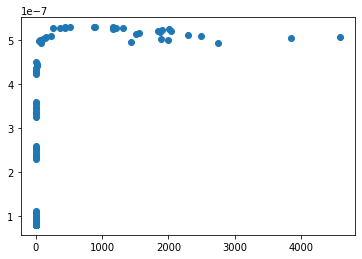

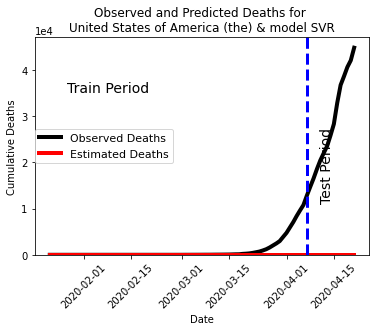

Train and Test MAE: 383.75, 314.60
Train and Test MAE forItaly: 2898.43, 21278.93


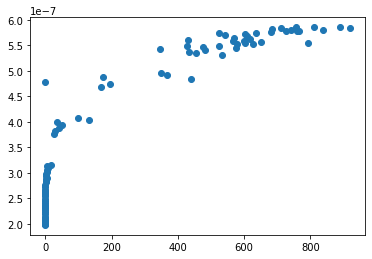

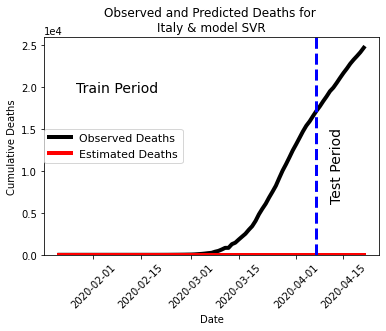

Train and Test MAE: 383.75, 314.60
Train and Test MAE forChina: 2195.99, 3804.57


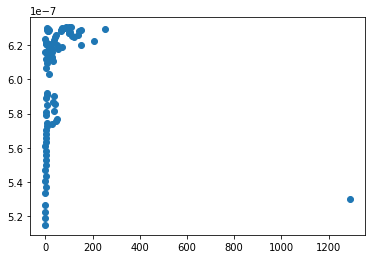

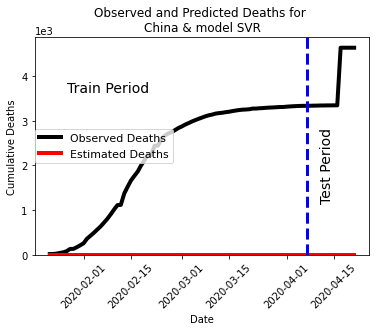

Train and Test MAE: 383.75, 314.60
Train and Test MAE forBangladesh: 1.47, 56.29


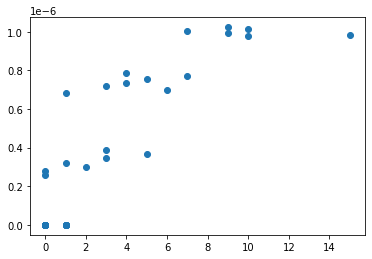

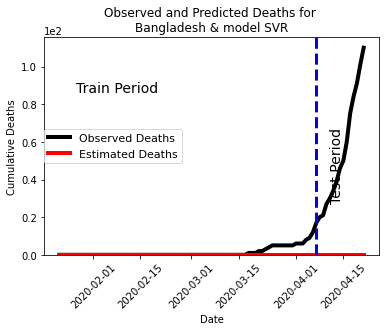

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False)

svmr= svm.SVR(C=1e-08, cache_size=200, coef0=0.0, degree=3, epsilon=1e-08, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svmr_fit = svmr.fit(x_train, y_train)
svmr_predic_tr = pd.DataFrame({'tr':svmr_fit.predict(x_train)})
svmr_predic_ts = pd.DataFrame({'ts':svmr_fit.predict(x_test)})



coun_list = ['United States of America (the)', 'Italy', 'China', 'Bangladesh']
for i in coun_list:
  plot_out(model = None, model_name = 'SVR',  
          country = i, tr_predict = svmr_predic_tr,
          ts_predict = svmr_predic_ts, dt_tr = dt_c_tr, dt_ts = dt_c_ts, 
            y_dt_tr = y_train,  y_dt_ts = y_test,
            math_scale=True, y_logscale=False)

## XGBoost Final Model


Train and Test MAE: 391.97, 322.14
Train and Test MAE forIndia: 18.58, 363.18


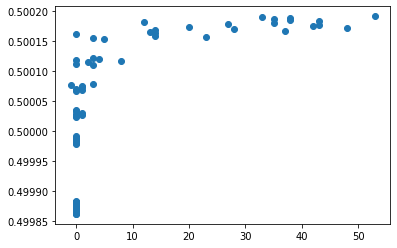

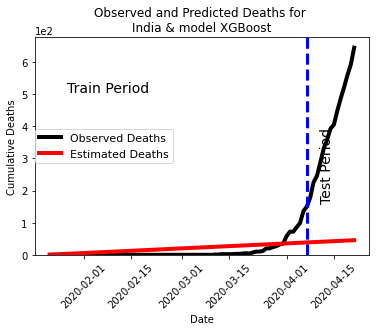

Train and Test MAE: 391.97, 322.14
Train and Test MAE forAfghanistan: 18.40, 17.66


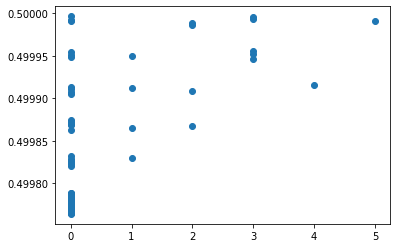

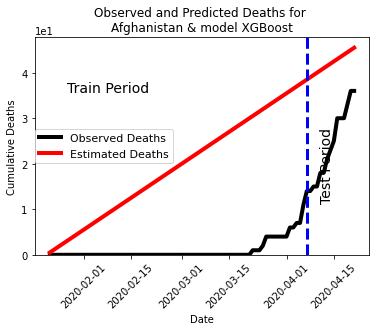

In [0]:
# x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
#                                                           random_var = False)

# xgbr = xgb.XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, eval_metric='mae',
#              gamma=3.3333337, importance_type='gain', learning_rate=1e-08,
#              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
#              n_estimators=200, n_jobs=1, nthread=None,
#              objective='reg:squarederror', random_state=0, reg_alpha=1e-08,
#              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
#              subsample=0.7, verbosity=0)

# xgbr_fit = xgbr.fit(x_train, y_train)
# xgbr_predic_tr = pd.DataFrame({'tr':xgbr_fit.predict(x_train)})
# xgbr_predic_ts = pd.DataFrame({'ts':xgbr_fit.predict(x_test)})

# coun_list = ['United States of America (the)', 'Italy', 'China', 'Bangladesh', 'Germany']

coun_list = ['India', 'Afghanistan']
for i in coun_list:
  plot_out(model = None, model_name = 'XGBoost',  
          country = i, tr_predict = xgbr_predic_tr,
          ts_predict = xgbr_predic_ts, dt_tr = dt_c_tr, dt_ts = dt_c_ts, 
            y_dt_tr = y_train,  y_dt_ts = y_test,
            math_scale=True, y_logscale=False)

## Neural Network Final Model

Train and Test MAE: 2172.07, 2314.88
Train and Test MAE forUnited States of America (the): 143.72, 10459.02


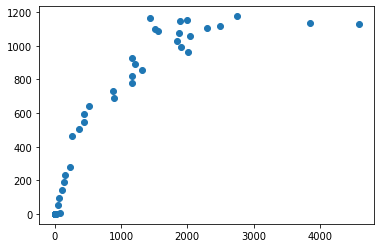

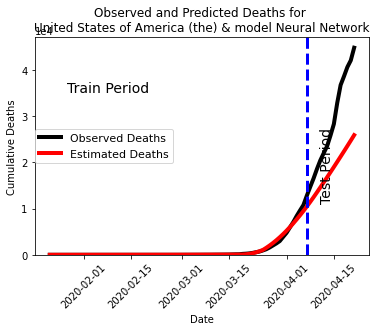

Train and Test MAE: 2172.07, 2314.88
Train and Test MAE forItaly: 395.64, 1247.01


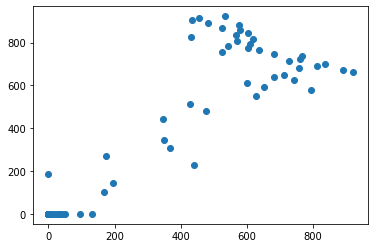

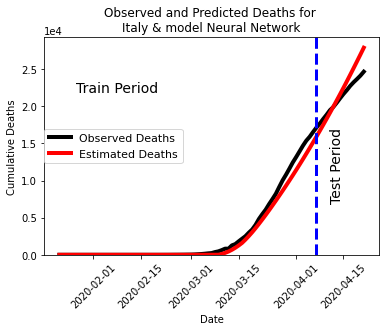

Train and Test MAE: 2172.07, 2314.88
Train and Test MAE forChina: 336.57, 1080.88


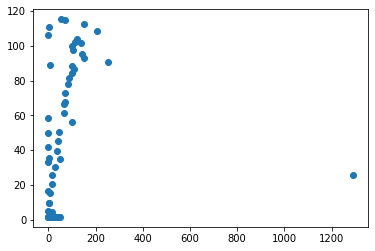

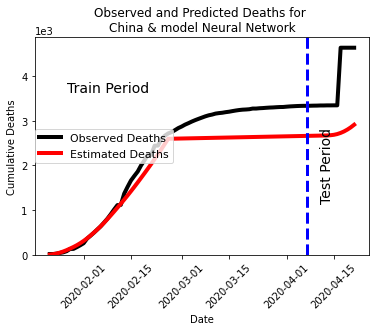

Train and Test MAE: 2172.07, 2314.88
Train and Test MAE forBangladesh: 4.20, 26.30


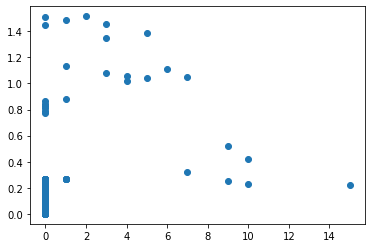

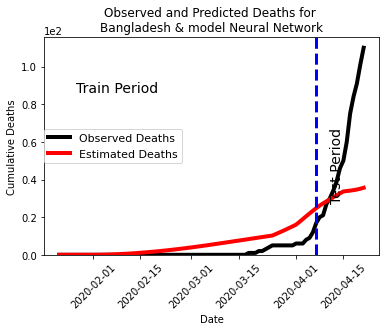

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False)

nnr= MLPRegressor(activation='relu', alpha=1e-08, batch_size='auto',
             beta_1=0.7499925025, beta_2=0.2499975075, early_stopping=True,
             epsilon=0.2500000075, hidden_layer_sizes=(20, 10, 5),
             learning_rate='adaptive', learning_rate_init=0.001, max_fun=15000,
             max_iter=2000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
             solver='adam', tol=0.0001, validation_fraction=0.15, verbose=False,
             warm_start=True)

nnr_fit = nnr.fit(x_train, y_train)
nnr_predic_tr = pd.DataFrame({'tr':nnr_fit.predict(x_train)})
nnr_predic_ts = pd.DataFrame({'ts':nnr_fit.predict(x_test)})

coun_list = ['United States of America (the)', 'Italy', 'China', 'Bangladesh']
for i in coun_list:
  plot_out(model = None, model_name = 'Neural Network',  
          country = i, tr_predict = nnr_predic_tr,
          ts_predict = nnr_predic_ts, dt_tr = dt_c_tr, dt_ts = dt_c_ts, 
            y_dt_tr = y_train,  y_dt_ts = y_test,
            math_scale=True, y_logscale=False)

## Random Forest Final Model


Train and Test MAE: 732.89, 722.76
Train and Test MAE forUnited States of America (the): 374.90, 19250.55


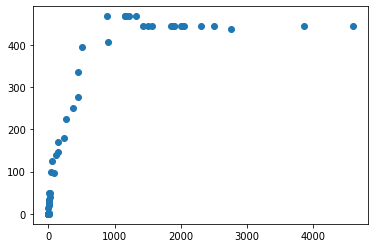

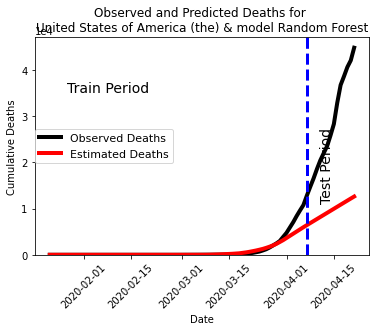

Train and Test MAE: 732.89, 722.76
Train and Test MAE forItaly: 1247.86, 4760.96


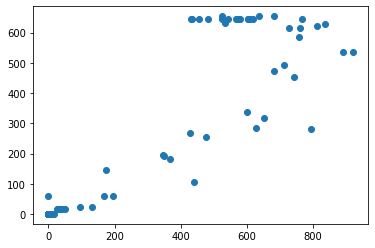

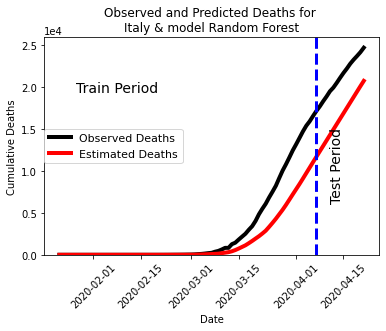

Train and Test MAE: 732.89, 722.76
Train and Test MAE forChina: 723.58, 793.61


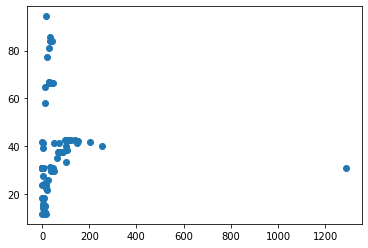

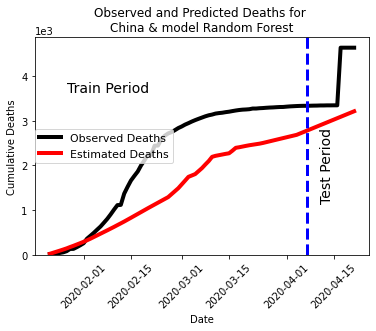

Train and Test MAE: 732.89, 722.76
Train and Test MAE forBangladesh: 1.23, 42.37


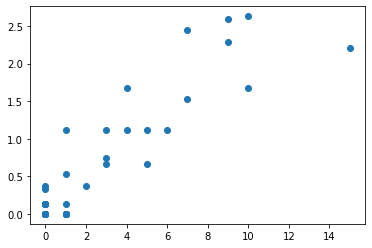

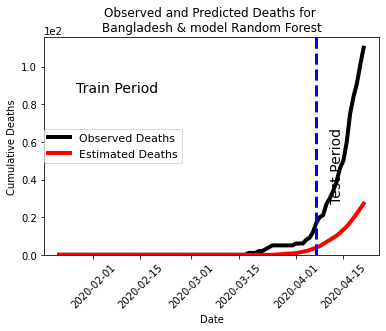

In [0]:
# Random Forest
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False)

rfr= RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=15,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)
rfr_fit = rfr.fit(x_train, y_train)
rfr_predic_tr = pd.DataFrame({'tr':rfr_fit.predict(x_train)})
rfr_predic_ts = pd.DataFrame({'ts':rfr_fit.predict(x_test)})

coun_list = ['United States of America (the)', 'Italy', 'China', 'Bangladesh']
for i in coun_list:
  plot_out(model = None, model_name = 'Random Forest',  
          country = i, tr_predict = rfr_predic_tr,
          ts_predict = rfr_predic_ts, dt_tr = dt_c_tr, dt_ts = dt_c_ts, 
            y_dt_tr = y_train,  y_dt_ts = y_test,
            math_scale=True, y_logscale=False)

## Spline Regression (All) Final Model

Train and Test MAE: 2314.61, 2331.45
Train and Test MAE forUnited States of America (the): 83.79, 9314.05


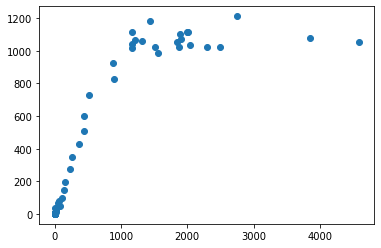

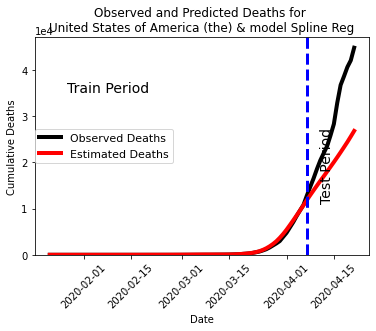

Train and Test MAE: 2314.61, 2331.45
Train and Test MAE forItaly: 972.75, 3496.74


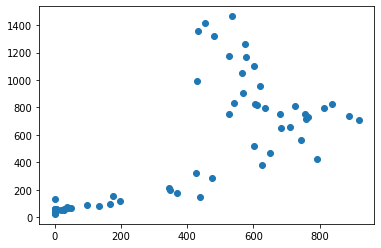

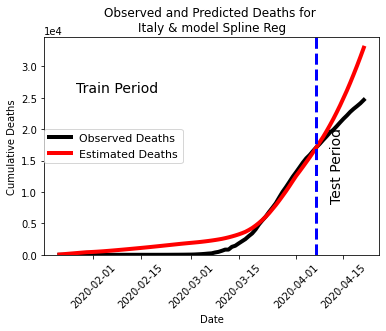

Train and Test MAE: 2314.61, 2331.45
Train and Test MAE forChina: 344.06, 496.89


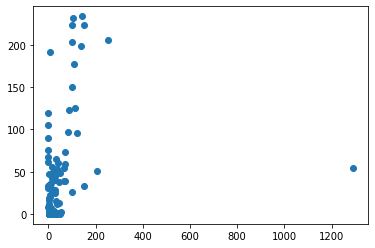

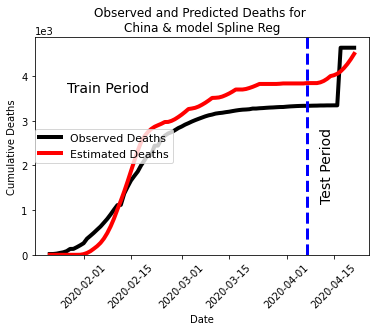

Train and Test MAE: 2314.61, 2331.45
Train and Test MAE forBangladesh: 18.24, 170.19


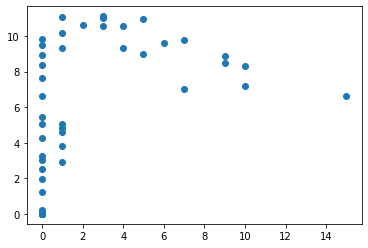

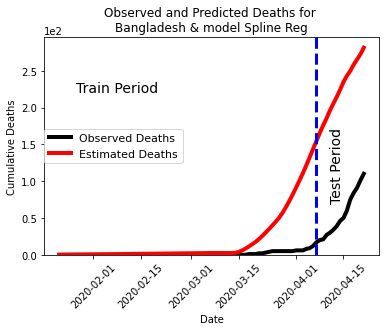

In [0]:
# SPR 0

x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False)

spr0= Earth(allow_linear=None, allow_missing=False, check_every=None,
      enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
      fast_h=None, feature_importance_type=None, max_degree=1, max_terms=None,
      min_search_points=None, minspan=None, minspan_alpha=None,
      penalty=25.454545456060604, smooth=True, thresh=None, use_fast=None,
      verbose=0, zero_tol=None)
spr0_fit = spr0.fit(x_train, y_train)
spr0_predic_tr = pd.DataFrame({'tr':spr0_fit.predict(x_train)})
spr0_predic_ts = pd.DataFrame({'ts':spr0_fit.predict(x_test)})

coun_list = ['United States of America (the)', 'Italy', 'China', 'Bangladesh']
for i in coun_list:
  plot_out(model = None, model_name = 'Spline Reg',  
          country = i, tr_predict = spr0_predic_tr,
          ts_predict = spr0_predic_ts, dt_tr = dt_c_tr, dt_ts = dt_c_ts, 
            y_dt_tr = y_train,  y_dt_ts = y_test,
            math_scale=True, y_logscale=False)

## Spline Regression (Subset 1) Final Model

Train and Test MAE: 1631.72, 1578.33
Train and Test MAE forUnited States of America (the): 87.11, 11638.08


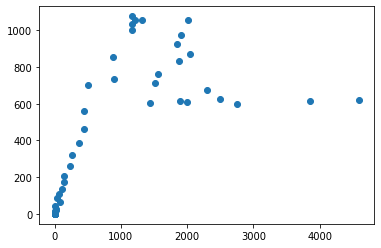

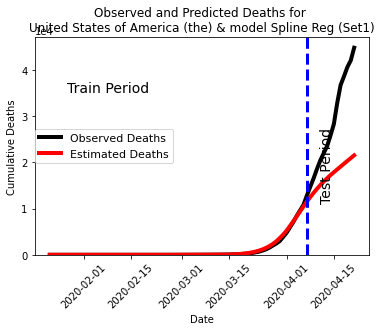

Train and Test MAE: 1631.72, 1578.33
Train and Test MAE forItaly: 902.37, 120.00


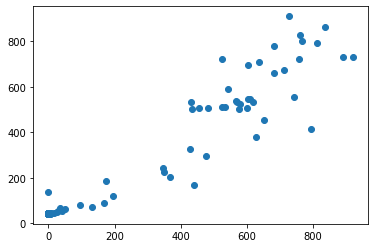

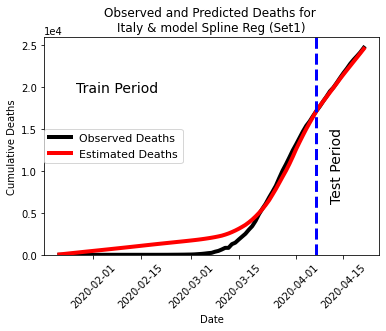

Train and Test MAE: 1631.72, 1578.33
Train and Test MAE forChina: 331.04, 467.74


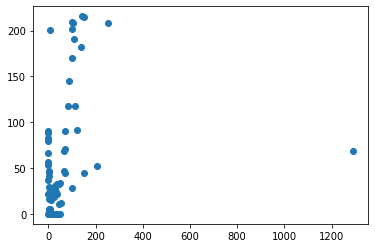

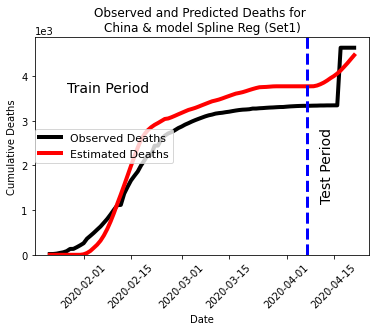

Train and Test MAE: 1631.72, 1578.33
Train and Test MAE forBangladesh: 5.16, 28.38


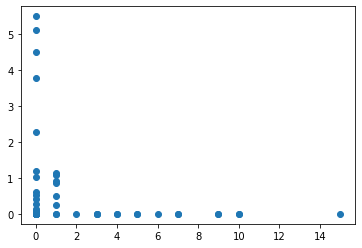

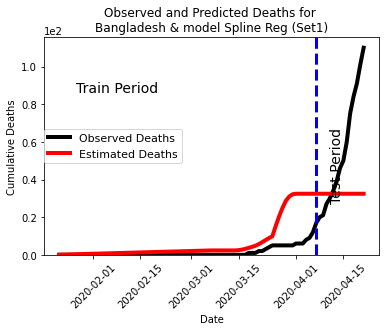

In [0]:
# SPR 1

x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = True, 
                                                          var_prop = .5, 
                                                          seed = 123)

spr1= Earth(allow_linear=None, allow_missing=False, check_every=None,
      enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
      fast_h=None, feature_importance_type=None, max_degree=1, max_terms=None,
      min_search_points=None, minspan=None, minspan_alpha=None,
      penalty=24.444444444444443, smooth=True, thresh=None, use_fast=None,
      verbose=0, zero_tol=None)
spr1_fit = spr1.fit(x_train, y_train)
spr1_predic_tr = pd.DataFrame({'tr':spr1_fit.predict(x_train)})
spr1_predic_ts = pd.DataFrame({'ts':spr1_fit.predict(x_test)})

coun_list = ['United States of America (the)', 'Italy', 'China', 'Bangladesh']
for i in coun_list:
  plot_out(model = None, model_name = 'Spline Reg (Set1)',  
          country = i, tr_predict = spr1_predic_tr,
          ts_predict = spr1_predic_ts, dt_tr = dt_c_tr, dt_ts = dt_c_ts, 
            y_dt_tr = y_train,  y_dt_ts = y_test,
            math_scale=True, y_logscale=False)

## Spline Regression (Subset 2) Final Model

Train and Test MAE: 6493.71, 8634.68
Train and Test MAE forUnited States of America (the): 93.20, 1128.31


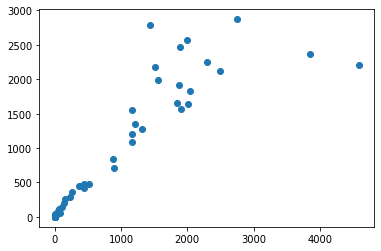

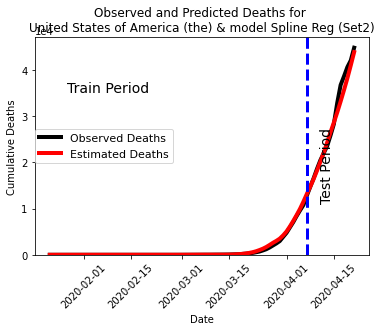

Train and Test MAE: 6493.71, 8634.68
Train and Test MAE forItaly: 270.93, 6170.33


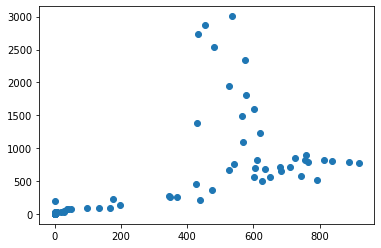

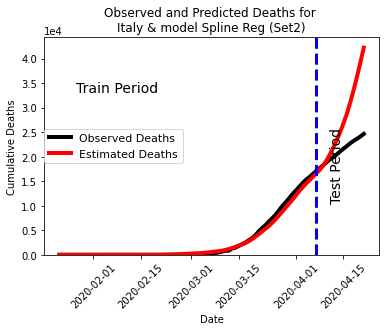

Train and Test MAE: 6493.71, 8634.68
Train and Test MAE forChina: 146.14, 2667.25


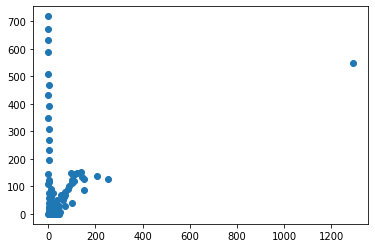

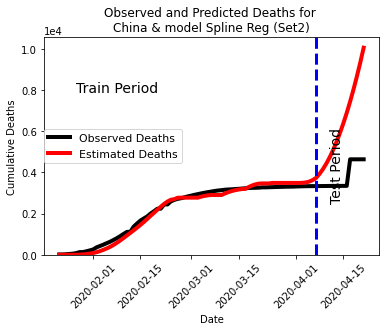

Train and Test MAE: 6493.71, 8634.68
Train and Test MAE forBangladesh: 1.89, 24.24


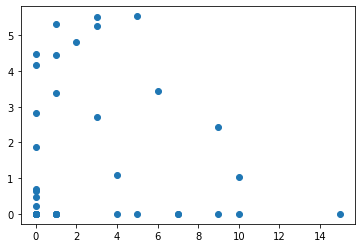

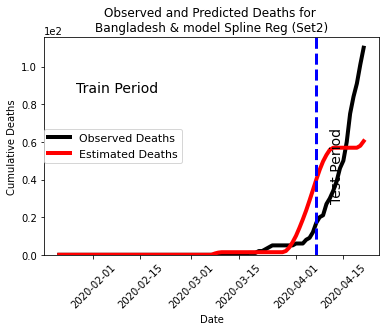

In [0]:
# SPR 3
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = True, 
                                                          var_prop = .5, 
                                                          seed = 342)

spr3= Earth(allow_linear=None, allow_missing=False, check_every=None,
      enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
      fast_h=None, feature_importance_type=None, max_degree=2, max_terms=None,
      min_search_points=None, minspan=None, minspan_alpha=None, penalty=1e-08,
      smooth=True, thresh=None, use_fast=None, verbose=0, zero_tol=None)

spr3_fit = spr3.fit(x_train, y_train)
spr3_predic_tr = pd.DataFrame({'tr':spr3_fit.predict(x_train)})
spr3_predic_ts = pd.DataFrame({'ts':spr3_fit.predict(x_test)})

coun_list = ['United States of America (the)', 'Italy', 'China', 'Bangladesh']
for i in coun_list:
  plot_out(model = None, model_name = 'Spline Reg (Set2)',  
          country = i, tr_predict = spr3_predic_tr,
          ts_predict = spr3_predic_ts, dt_tr = dt_c_tr, dt_ts = dt_c_ts, 
            y_dt_tr = y_train,  y_dt_ts = y_test,
            math_scale=True, y_logscale=False)



## Ensemble


Train and Test MAE: 1715.86, 2028.80
Train and Test MAE forUnited States of America (the): 309.41, 15640.98


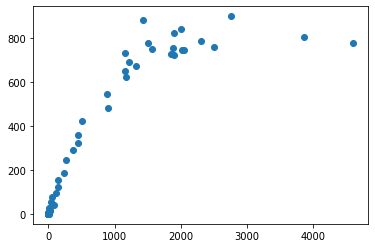

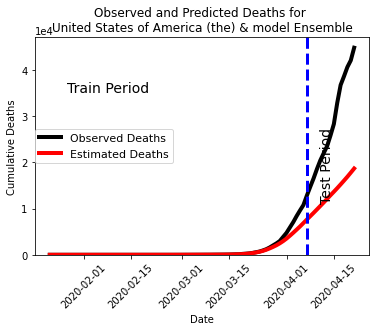

Train and Test MAE: 1715.86, 2028.80
Train and Test MAE forItaly: 1246.25, 5277.60


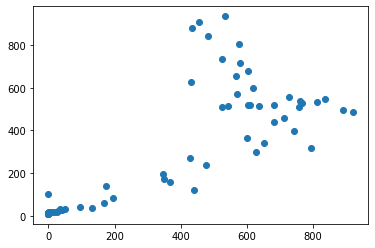

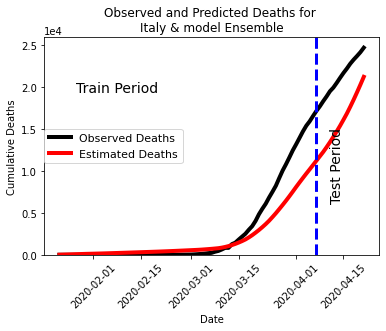

Train and Test MAE: 1715.86, 2028.80
Train and Test MAE forChina: 780.45, 1043.37


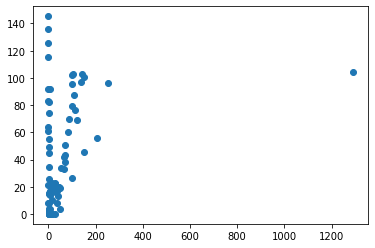

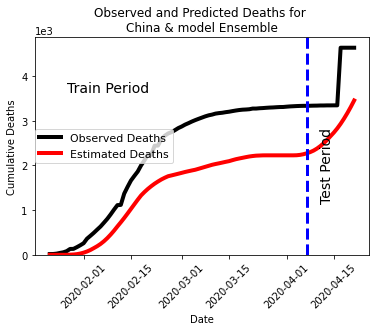

Train and Test MAE: 1715.86, 2028.80
Train and Test MAE forBangladesh: 4.49, 24.31


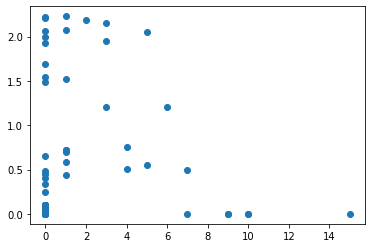

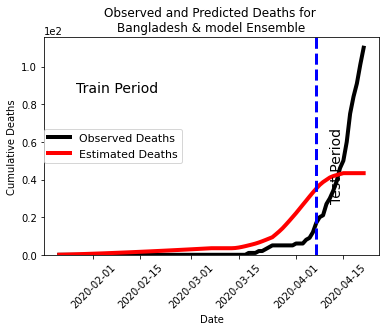

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = True, 
                                                          var_prop = .5, 
                                                          seed = 342)
predict_tr = pd.DataFrame({'nnr': nnr_predic_tr['tr'].reset_index(drop = True),
                           'xgbr': xgbr_predic_tr['tr'].reset_index(drop = True),
                           'svr': svmr_predic_tr['tr'].reset_index(drop = True),
                           'RF': rfr_predic_tr['tr'].reset_index(drop = True),
                           'SPR0': spr0_predic_tr['tr'].reset_index(drop = True),
                           'SPR1': spr1_predic_tr['tr'].reset_index(drop = True),
                           'SPR3': spr3_predic_tr['tr'].reset_index(drop = True)})

predict_ts = pd.DataFrame({'nnr': nnr_predic_ts['ts'].reset_index(drop = True),
                           'xgbr': xgbr_predic_ts['ts'].reset_index(drop = True),
                           'svr': svmr_predic_ts['ts'].reset_index(drop = True),
                           'RF': rfr_predic_ts['ts'].reset_index(drop = True),
                           'SPR0': spr0_predic_ts['ts'].reset_index(drop = True),
                           'SPR1': spr1_predic_ts['ts'].reset_index(drop = True),
                           'SPR3': spr3_predic_ts['ts'].reset_index(drop = True)})

predict_tr_ens = predict_tr.mean(axis = 1)
predict_ts_ens = predict_ts.mean(axis = 1)
# print(predict_ts_ens.shape, y_test.shape, x_test.shape, dt_c_ts.shape)
coun_list = ['United States of America (the)', 'Italy', 'China', 'Bangladesh']
for i in coun_list:
  plot_out(model = None, model_name = 'Ensemble',  
          country = i, tr_predict = predict_tr_ens,
          ts_predict = predict_ts_ens, dt_tr = dt_c_tr, dt_ts = dt_c_ts, 
            y_dt_tr = y_train,  y_dt_ts = y_test,
            math_scale=True, y_logscale=False)


In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False)
# pipe = [ ('rfr', rfr), ('svmr', svmr), ('xgbr', xgbr), ('spr', spr)]
pipe = [ ('rfr', rfr),  ('spr0', spr0), ('nnr': nnr)]
eclf = VotingRegressor(estimators=pipe, weights=None)

eclf.fit(x_train, y_train)



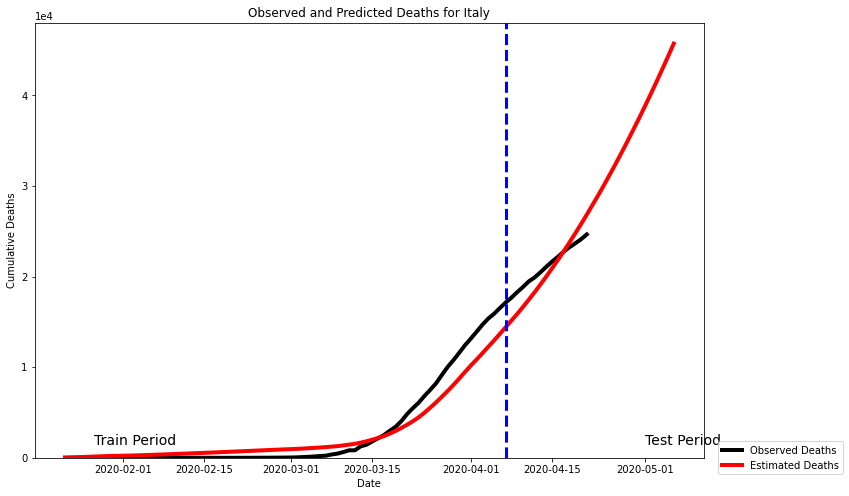

In [0]:
x_train, y_train, x_test, y_test, selected_var, dt_c_tr, dt_c_ts = fit_data(dt = dta, 
                                                          random_var = False)

plot_out(model = eclf, model_name = 'Unweighted Ensemble', 
         country = "Italy", dt_tr = dt_c_tr, dt_ts = dt_c_ts, x_dt_tr = x_train, 
          y_dt_tr = y_train, x_dt_ts = x_test, y_dt_ts = y_test,
          math_scale=True, y_logscale=False)

Timestamp('2020-01-22 00:00:00')

In [0]:
n = 500
weight = pd.DataFrame({'w1': np.random.uniform(0, 5, n),
                      'w2': np.random.uniform(0, 5, n),
                      'w3': np.random.uniform(0, 5, n),
                      'w4': np.random.uniform(0, 5, n)})

# weight = weight.div(weight.sum(axis = 1), axis=0)
# weight.append([1,1,1,1,])
weight['accuracy'] = np.nan 

for i in range(weight.shape[0]):
    eclf2 = VotingClassifier(estimators=pipe, voting='soft', weights = weight.iloc[i,:4].ravel())
    
    scores = cross_val_score(estimator=eclf2,  X=X_tr_std, y=y_train.ravel(), cv=3, scoring='accuracy')
    
    weight.iloc[i, 4] = scores.mean()
    
kkk = weight['accuracy'].idxmax()

eclf2 = VotingClassifier(estimators=pipe, voting='soft', weights = weight.iloc[kkk,:4].ravel())
eclf2.fit(X_tr_std, y_train)